Using device: cuda


c:\Users\JackSchwartz\jupyter_notebooks\blaze-net\wildfire-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\JackSchwartz\jupyter_notebooks\blaze-net\wildfire-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\JackSchwartz\AppData\Local\Temp\ipykernel_22976\595211876.py:88: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/5


  0%|          | 0/946 [00:00<?, ?it/s]C:\Users\JackSchwartz\AppData\Local\Temp\ipykernel_22976\595211876.py:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
100%|██████████| 946/946 [03:03<00:00,  5.15it/s]
C:\Users\JackSchwartz\AppData\Local\Temp\ipykernel_22976\595211876.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision in validation


Train Loss: 0.1421, Val Loss: 0.0959, Val Accuracy: 96.70%

Epoch 2/5


100%|██████████| 946/946 [03:02<00:00,  5.19it/s]


Train Loss: 0.0853, Val Loss: 0.0582, Val Accuracy: 98.19%

Epoch 3/5


100%|██████████| 946/946 [03:01<00:00,  5.21it/s]


Train Loss: 0.0712, Val Loss: 0.1028, Val Accuracy: 96.24%

Epoch 4/5


100%|██████████| 946/946 [03:01<00:00,  5.21it/s]


Train Loss: 0.0565, Val Loss: 0.0988, Val Accuracy: 96.48%

Epoch 5/5


100%|██████████| 946/946 [03:00<00:00,  5.25it/s]


Train Loss: 0.0460, Val Loss: 0.1363, Val Accuracy: 95.81%
Model saved as 'wildfire_model.pth'


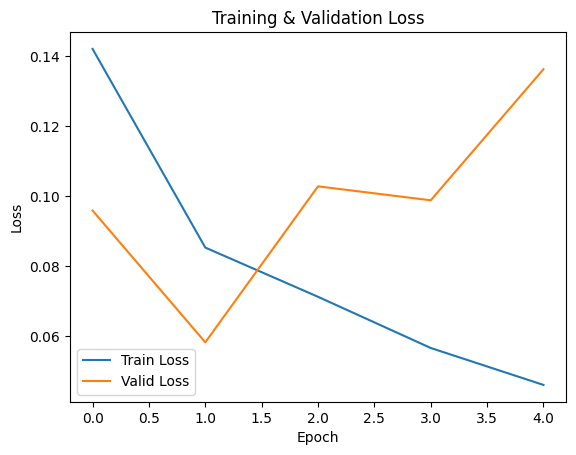

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow truncated images to load
# Mixed precision utilities
from torch.cuda.amp import autocast, GradScaler

# 1. Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define absolute paths for your dataset
data_dir = r"C:\Users\JackSchwartz\jupyter_notebooks\blaze-net\wildfire_prediction_images"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")

# 3. Image transformations (with optional data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # Uncomment for augmentation:
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Optional: Load images with PIL if they are truncated
def safe_pil_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except Exception as e:
        print(f"Warning: Unable to load image {path}. Substituting with a blank image. Error: {e}")
        # Return a blank image of the size expected by your transform (here, 224x224)
        return Image.new("RGB", (224, 224), (0, 0, 0))

# 4. Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)

# 5. Create DataLoaders (tune batch_size to your GPU memory)
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,        # Use more workers to load data faster
    pin_memory=True,
    persistent_workers=False
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False
)

# 6. Load a pretrained ResNet18 and modify final layer
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # for binary classification: wildfire vs. no wildfire
model = model.to(device)

# 7. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 8. Mixed precision scaler
scaler = GradScaler()

# 9. Training function with mixed precision
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=5):
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast():  # Mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        # Training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast():  # Mixed precision in validation
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        accuracy = (correct / total) * 100

        print(f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {valid_loss:.4f}, "
              f"Val Accuracy: {accuracy:.2f}%")

    return train_losses, valid_losses

# 10. Run training
epochs = 5
train_losses, valid_losses = train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=epochs)

# 11. Save the model
torch.save(model.state_dict(), "wildfire_model.pth")
print("Model saved as 'wildfire_model.pth'")

# 12. Plot the training progress
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


In [2]:
import os
from PIL import Image, ImageFile

# Allow PIL to try loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def remove_truncated_images(directory):
    removed = 0
    total = 0
    # Walk through all files in the directory (and subdirectories)
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                total += 1
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        # The verify() method checks for file integrity
                        img.verify()
                except Exception as e:
                    print(f"Removing corrupted image: {file_path} (Error: {e})")
                    os.remove(file_path)
                    removed += 1
    print(f"Processed {total} images in {directory}. Removed {removed} corrupted files.")

# Replace these paths with your actual dataset paths
train_dir = r"C:\Users\JackSchwartz\jupyter_notebooks\blaze-net\wildfire_prediction_images\train"
valid_dir = r"C:\Users\JackSchwartz\jupyter_notebooks\blaze-net\wildfire_prediction_images\valid"
test_dir = r"C:\Users\JackSchwartz\jupyter_notebooks\blaze-net\wildfire_prediction_images\test"

remove_truncated_images(train_dir)
remove_truncated_images(valid_dir)
remove_truncated_images(test_dir)


Processed 30250 images in C:\Users\JackSchwartz\jupyter_notebooks\blaze-net\wildfire_prediction_images\train. Removed 0 corrupted files.
Processed 6300 images in C:\Users\JackSchwartz\jupyter_notebooks\blaze-net\wildfire_prediction_images\valid. Removed 0 corrupted files.
Processed 6300 images in C:\Users\JackSchwartz\jupyter_notebooks\blaze-net\wildfire_prediction_images\test. Removed 0 corrupted files.
